In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt

In [2]:
!pip install seaborn==0.12.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import seaborn as sns
sns.__version__

'0.12.0'

In [4]:
pd.__version__

'1.3.4'

In [5]:
perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240808/sars-cov-2/uniprot/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/msl128vs30cls_s64/processed/tl_tf_multi_sarscov2-S-WIV04ref.csv_WIV04.csv")
#perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240710/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_cls_hybrid_attn_fnn_2l_lr1e-4/aligned_msl128_s64/processed/tl_tf_multi_coronaviridae_s_uniref90_sars_cov_2_aligned.csv_WIV04.csv")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes = ["Pig", "Human", "Cat", "Dromedary camel", "Cattle", "Chicken", "Gray wolf", "Yak"]

In [6]:
def get_perturbation_output(perturbation_output_filepath):
    df = pd.read_csv(perturbation_output_filepath)
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]

    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    df["orig_y_pred"] = orig_pred_class
    df["new_y_pred"] = df[classes].idxmax(axis=1)
    return df

In [7]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [8]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

In [9]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [10]:
perturbed_output_df = get_perturbation_output(perturbation_output_filepath)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

perturbed_output_df shape = (31826, 17)


In [11]:
perturbed_output_df

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred
0,0.417198,0.000354,0.000942,0.012353,0.004716,0.462407,0.101951,0.000079,WIV04,Human,N,800,I,0.000059,0.000059,Human,Human
1,0.446220,0.000369,0.001280,0.011228,0.008226,0.313025,0.219536,0.000116,WIV04,Human,G,34,F,-0.149323,0.149323,Human,Cat
2,0.416533,0.000360,0.000965,0.012354,0.004747,0.462516,0.102442,0.000081,WIV04,Human,Y,659,J,0.000168,0.000168,Human,Human
3,0.417758,0.000353,0.000935,0.012447,0.004738,0.461894,0.101796,0.000079,WIV04,Human,P,861,I,-0.000454,0.000454,Human,Human
4,0.435705,0.000372,0.001119,0.011920,0.006043,0.399289,0.145457,0.000096,WIV04,Human,N,120,V,-0.063059,0.063059,Human,Cat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31821,0.418224,0.000354,0.000948,0.012317,0.004761,0.459731,0.103586,0.000080,WIV04,Human,G,998,M,-0.002617,0.002617,Human,Human
31822,0.417219,0.000354,0.000942,0.012350,0.004716,0.462348,0.101991,0.000079,WIV04,Human,F,1255,I,0.000000,0.000000,Human,Human
31823,0.417148,0.000351,0.000941,0.012228,0.004684,0.462359,0.102212,0.000078,WIV04,Human,D,567,F,0.000011,0.000011,Human,Human
31824,0.417365,0.000353,0.000943,0.012299,0.004713,0.461881,0.102367,0.000079,WIV04,Human,L,937,G,-0.000467,0.000467,Human,Human


In [12]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_pos"].isna()]

In [13]:
perturbed_output_df["perturb_pos"] = perturbed_output_df["perturb_pos"] + 1

# Overview

### Distribution of Human class difference

In [14]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [15]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 855 (2.6864827499528685)
Distribution of full perturbation output
n=31826
       start       end  count  percentage
0  -0.357903 -0.321599     15    0.047131
1  -0.321599 -0.285295     35    0.109973
2  -0.285295 -0.248992     56    0.175957
3  -0.248992 -0.212688     86    0.270219
4  -0.212688 -0.176384     67    0.210520
5  -0.176384 -0.140080     96    0.301640
6  -0.140080 -0.103777     95    0.298498
7  -0.103777 -0.067473    258    0.810658
8  -0.067473 -0.031169    677    2.127192
9  -0.031169  0.005135  24677   77.537234
10  0.005135  0.041438   4416   13.875448
11  0.041438  0.077742    773    2.428832
12  0.077742  0.114046    284    0.892352
13  0.114046  0.150349    134    0.421039
14  0.150349  0.186653     64    0.201093
15  0.186653  0.222957     35    0.109973
16  0.222957  0.259261     18    0.056558
17  0.259261  0.295564      6    0.018853
18  0.295564  0.331868     28    0.087978
19  0.331868  0.368172      6    

<Figure size 432x288 with 0 Axes>

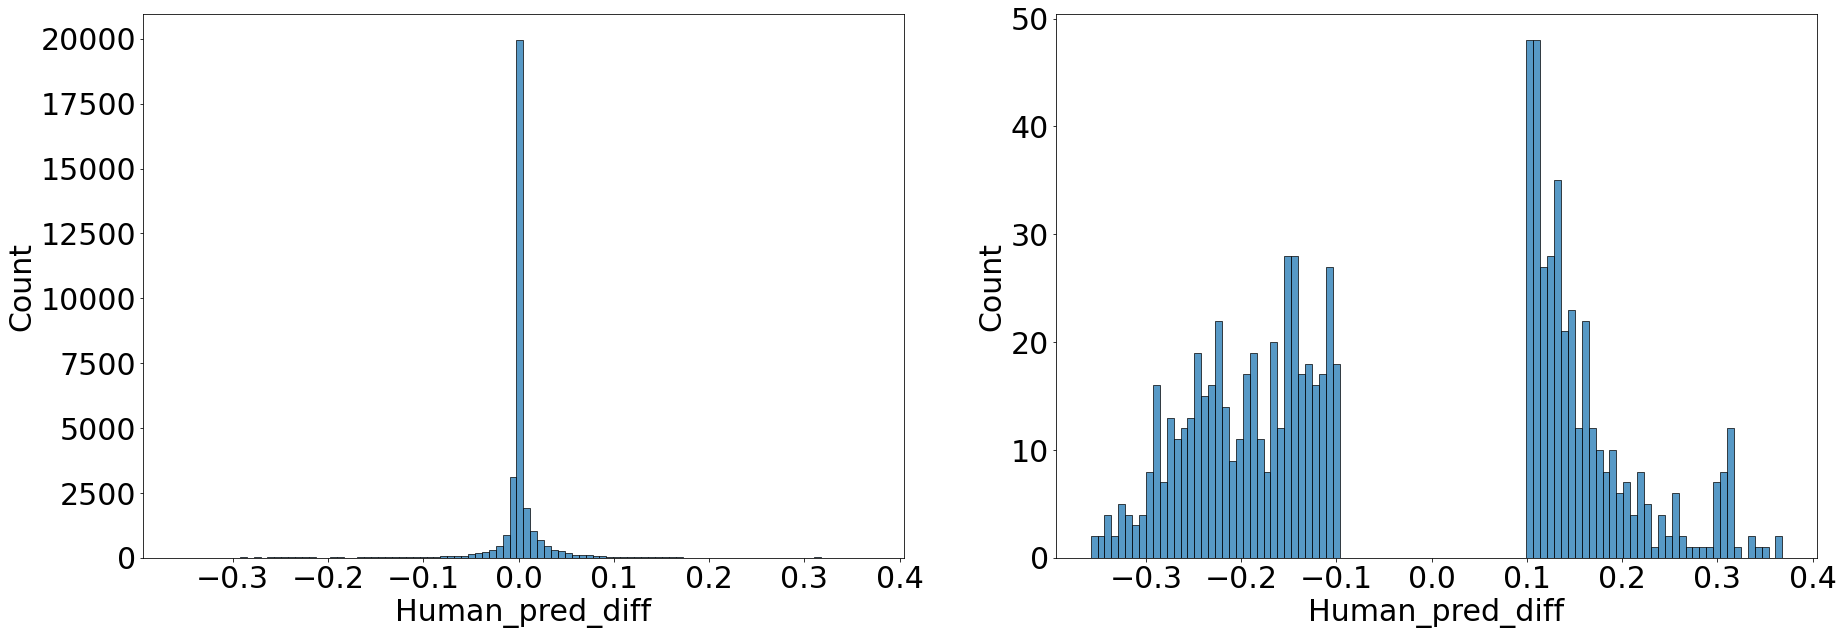

In [16]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

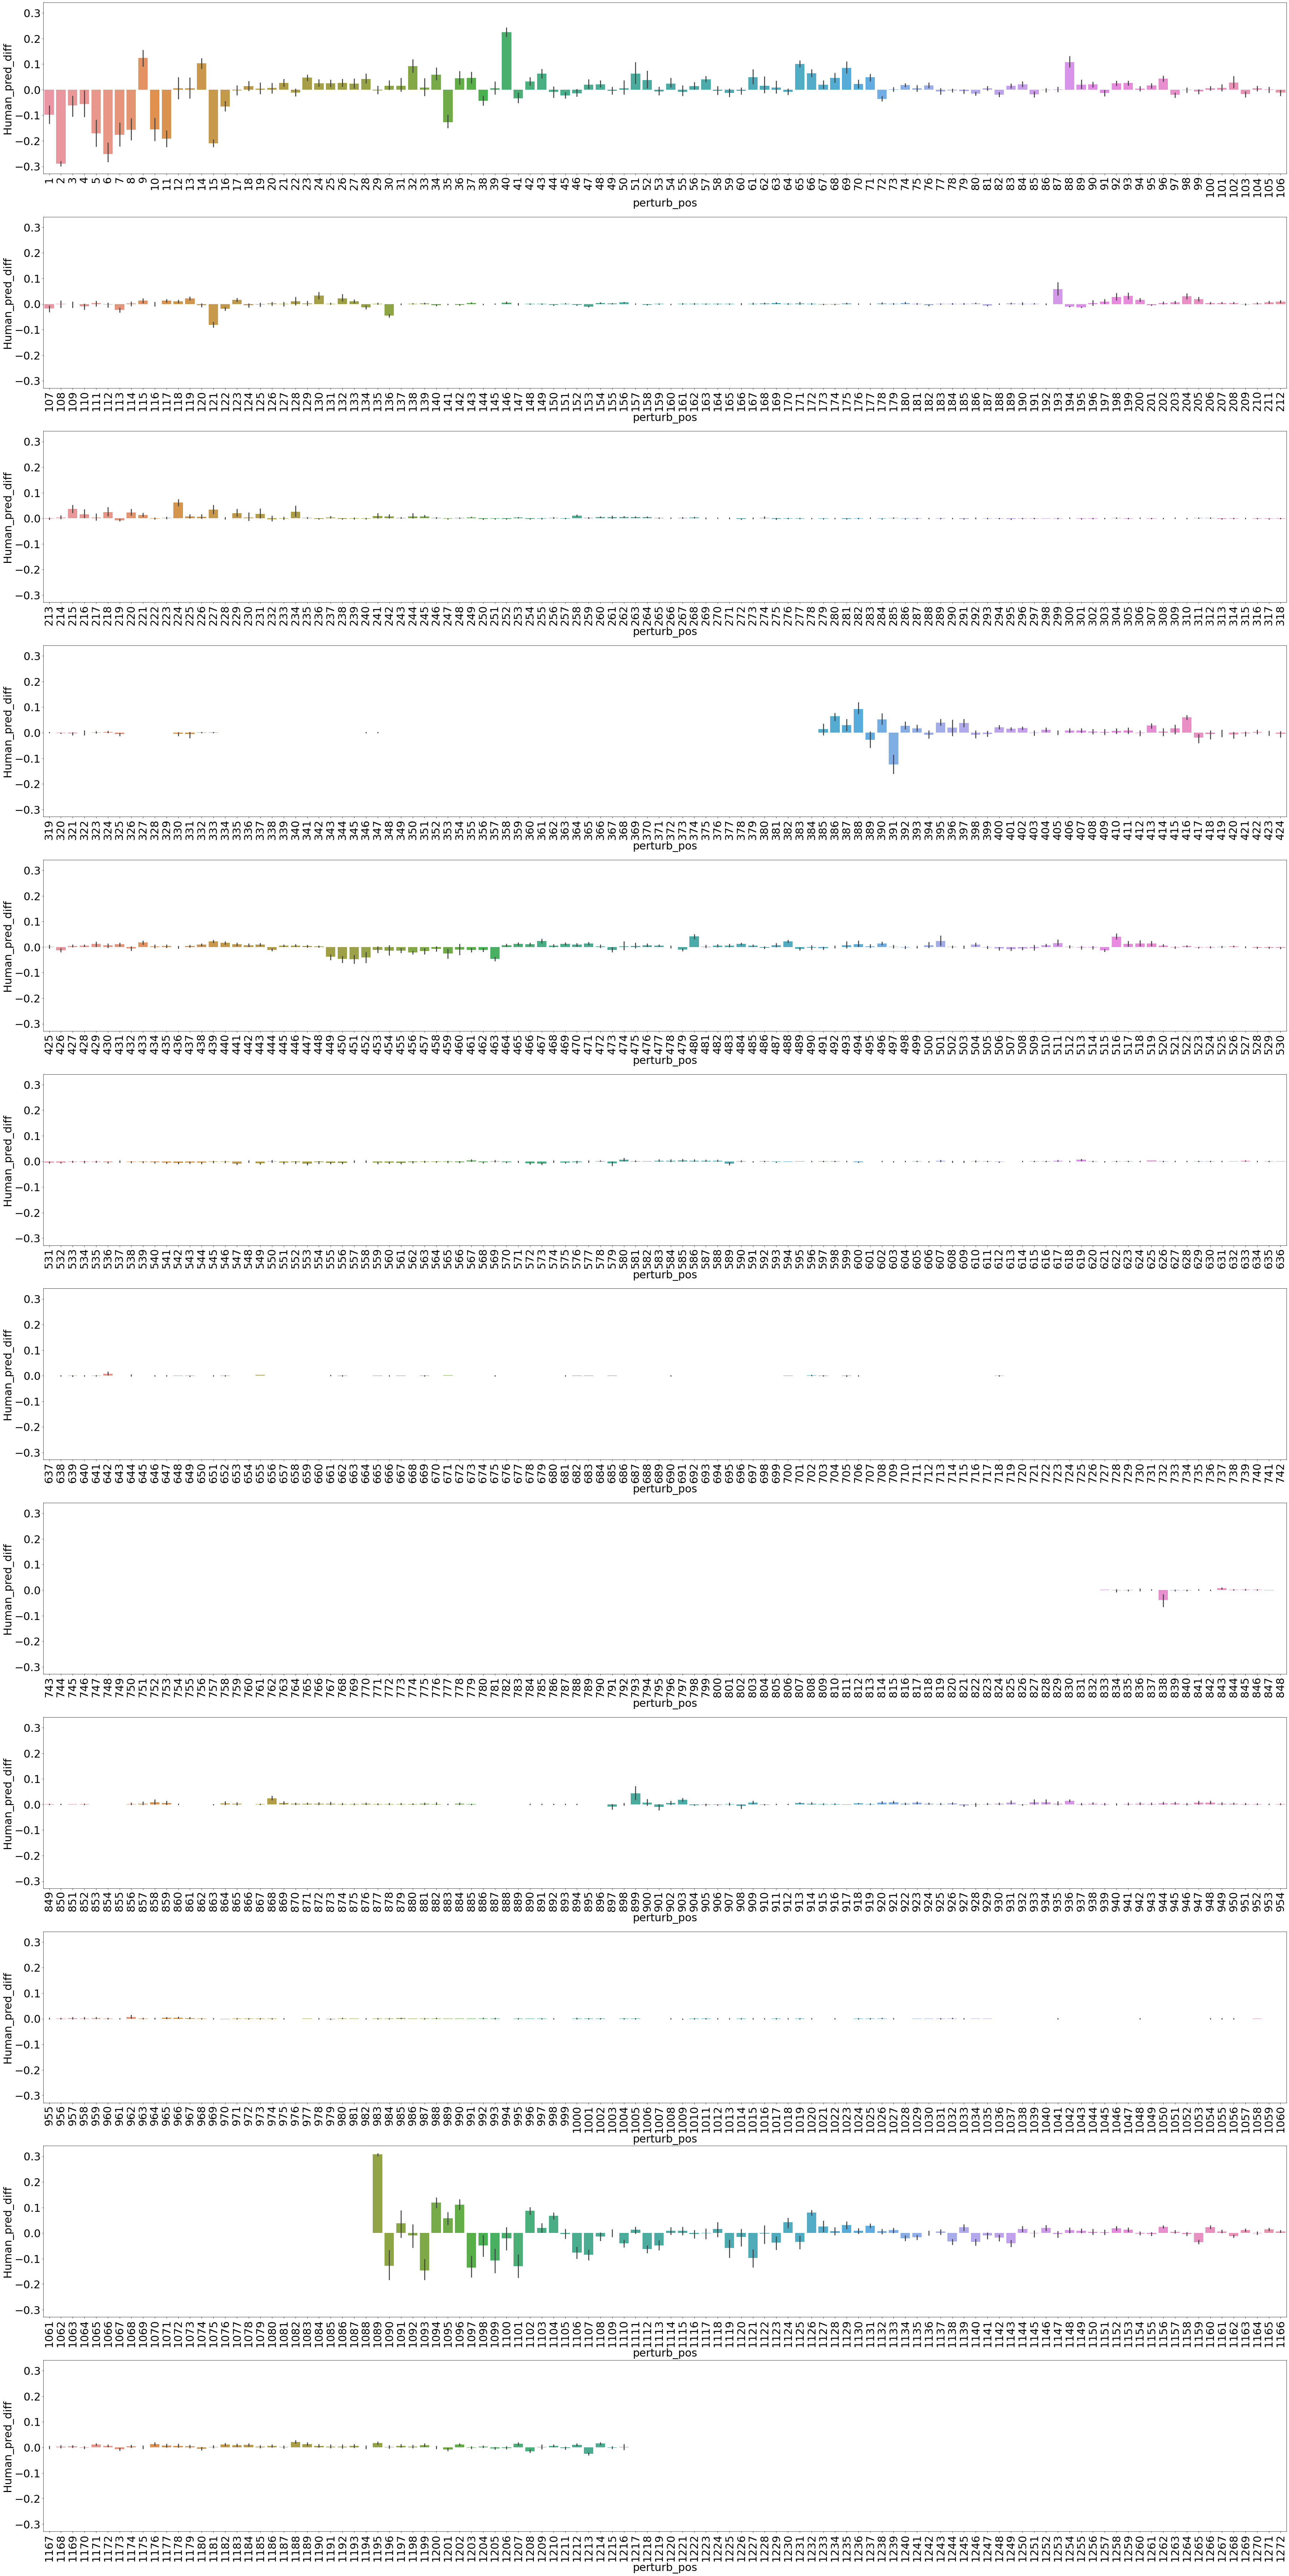

In [17]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
n = 12
fig, axs = plt.subplots(n, 1, figsize=(50, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(sorted(perturbed_output_df["perturb_pos"].unique())), n)

for i in range(n):
    sns.barplot(perturbed_output_df[perturbed_output_df["perturb_pos"].isin(bins[i])], x="perturb_pos", y=pred_diff_col, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: mean=0 and variance=0

In [18]:
mean_std_df = perturbed_output_df.groupby("perturb_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_pos"].isin(cut_off_pos)]
cut_off_pos_1 = set(cut_off_df_1["perturb_pos"].unique())
len(cut_off_pos_1)


1216

<Figure size 432x288 with 0 Axes>

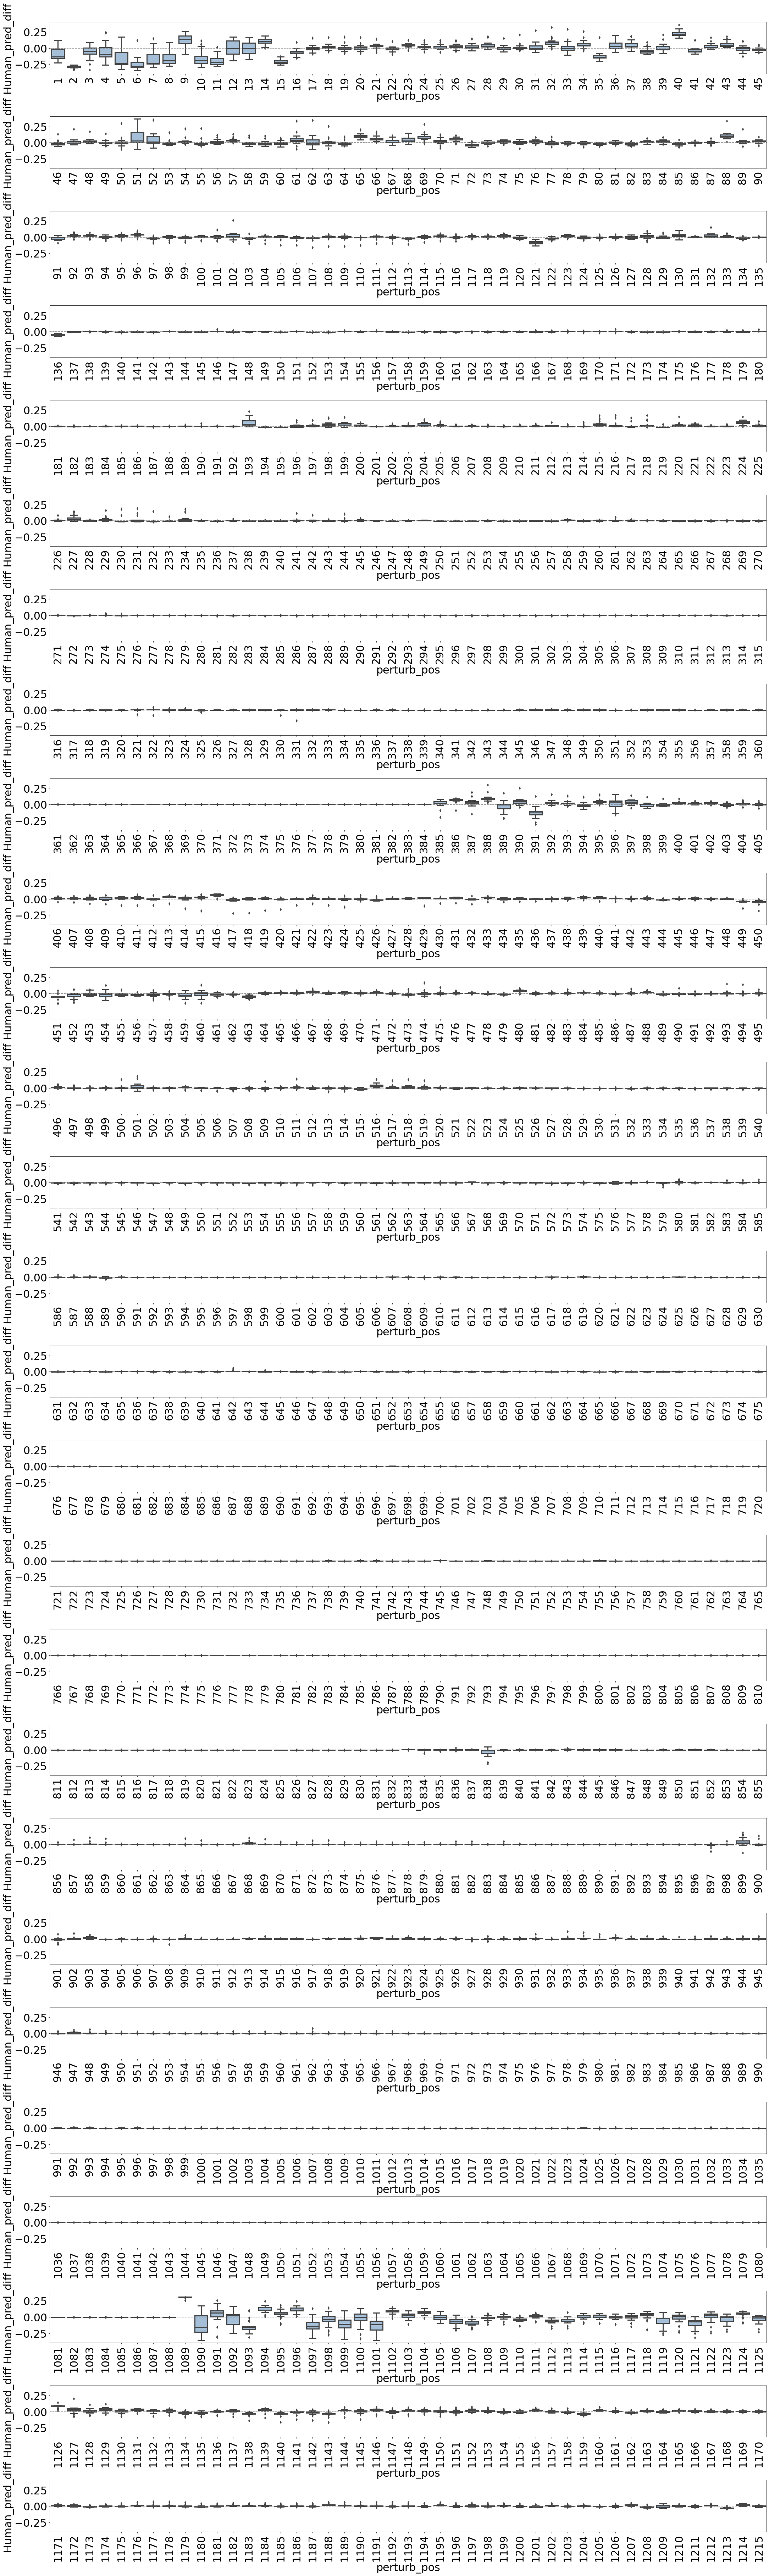

In [19]:
plt.clf()
n = 27
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(n, 1, figsize=(30, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(cut_off_pos_1), n)

for i in range(n):
    sns.boxplot(data=cut_off_df_1[cut_off_df_1["perturb_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [20]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_2 = set(cut_off_df_2["perturb_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 1216
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 189
1 intersection 2: 189
1 minus 2: 1027
2 minus 1: 0
is 2 subset of 1: True


<Figure size 432x288 with 0 Axes>

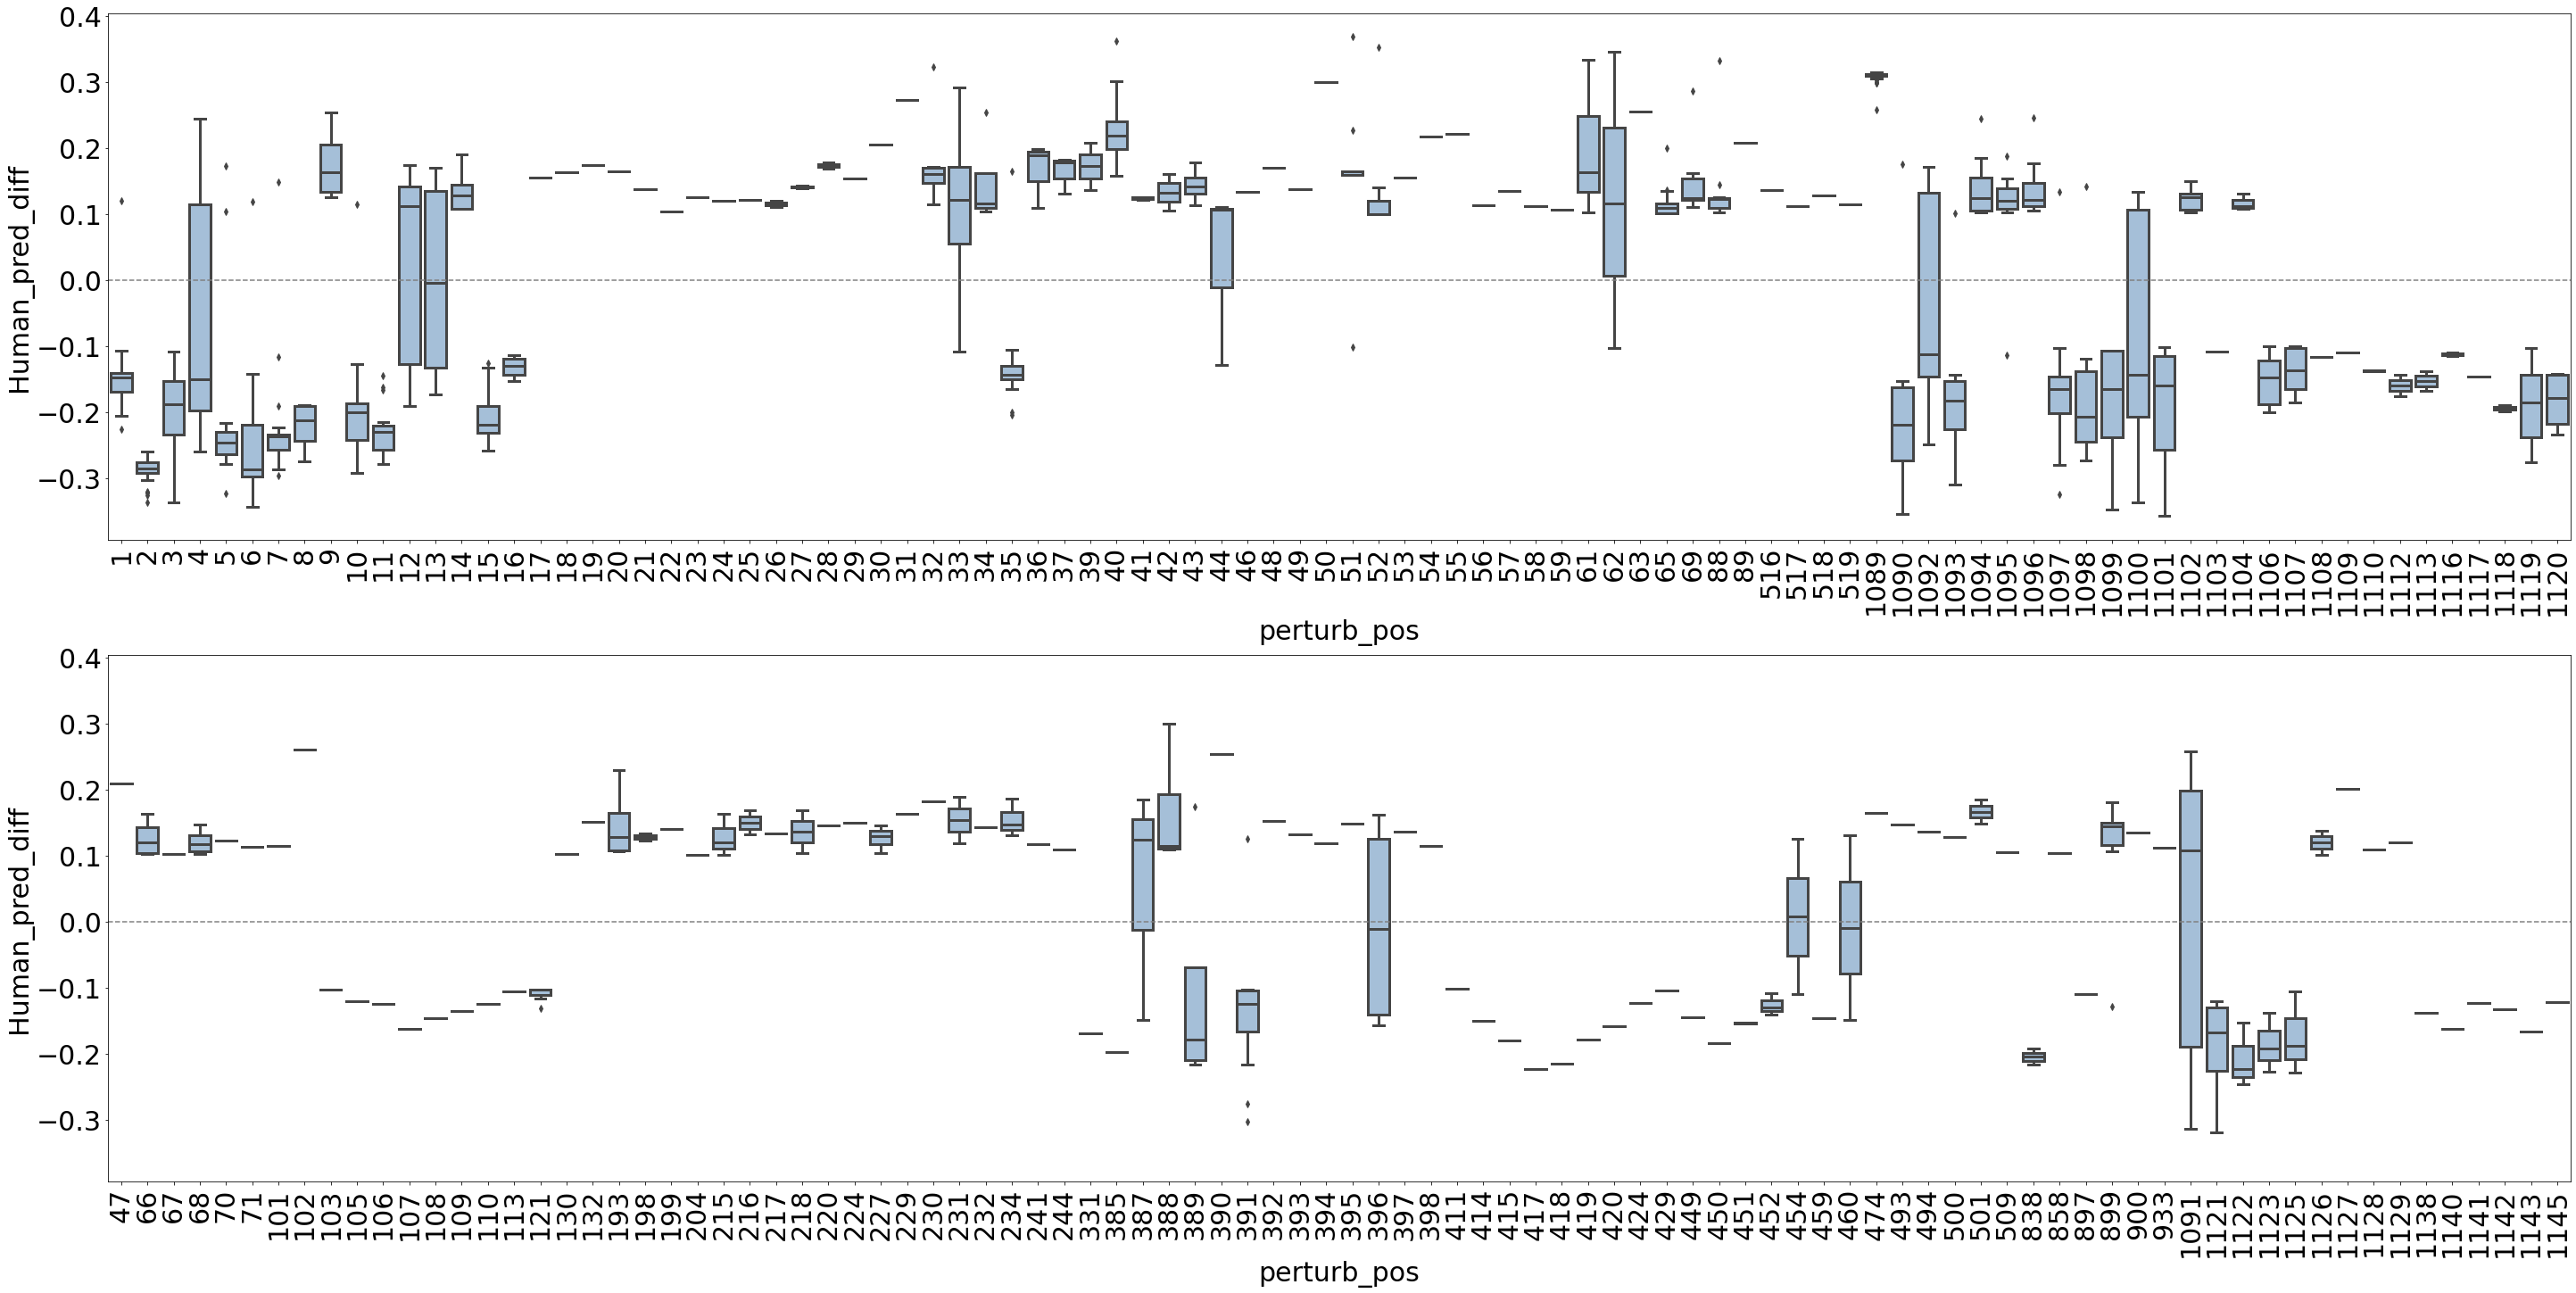

In [21]:
plt.clf()
n = 2
fig, axs = plt.subplots(n, 1, figsize=(40, 20), sharey=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

bins = get_uniformly_divided_position_bins(list(cut_off_pos_2), n)

for i in range(n):
    sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")

plt.tight_layout(pad=.1)
plt.show()


## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [22]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

/tmp/ipykernel_3625196/3757831376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_pos"].astype("str") + cut_off_df_2["new_token"]


<Figure size 432x288 with 0 Axes>

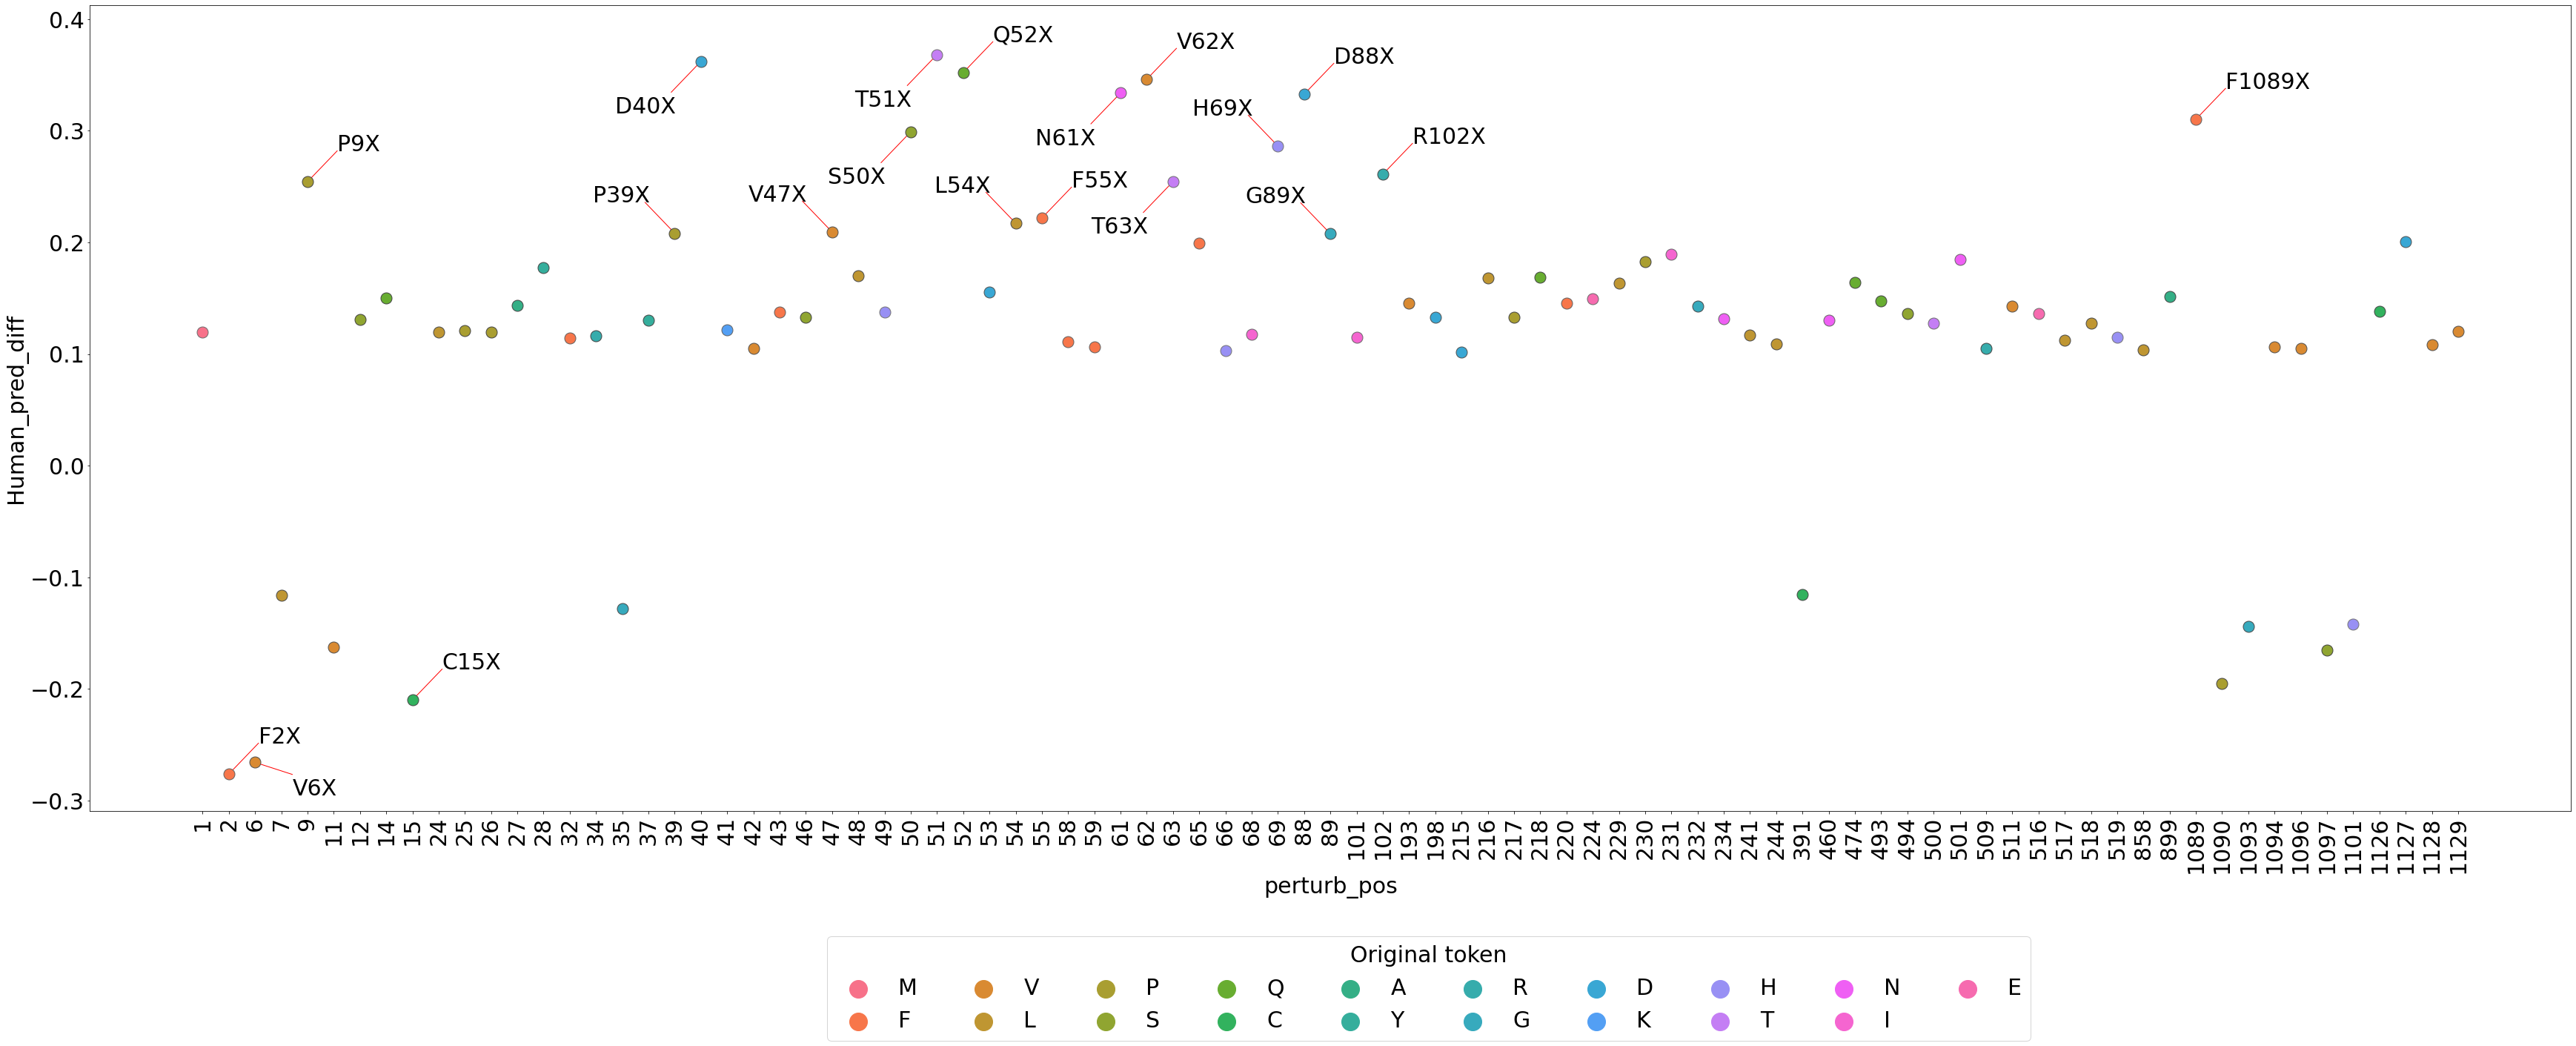

In [23]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(60, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [24]:
annotate_df

,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturbation_id
26685,0.156583,0.000276,0.000395,0.006178,0.000428,0.830520,0.005602,0.000019,WIV04,Human,T,51,X,0.368172,0.368172,Human,Human,T51X
17786,0.163512,0.000232,0.000387,0.005073,0.000385,0.824506,0.005889,0.000015,WIV04,Human,D,40,X,0.362159,0.362159,Human,Human,D40X
11416,0.168907,0.000334,0.000454,0.008042,0.000600,0.814434,0.007203,0.000027,WIV04,Human,Q,52,X,0.352086,0.352086,Human,Human,Q52X
12497,0.174590,0.000343,0.000500,0.007696,0.000620,0.808507,0.007716,0.000028,WIV04,Human,V,62,X,0.346159,0.346159,Human,Human,V62X
31660,0.184769,0.000333,0.000484,0.008476,0.000711,0.796185,0.009014,0.000029,WIV04,Human,N,61,X,0.333837,0.333837,Human,Human,N61X
20242,0.185915,0.000419,0.000658,0.008042,0.000753,0.795092,0.009086,0.000036,WIV04,Human,D,88,X,0.332744,0.332744,Human,Human,D88X
9593,0.174924,0.001729,0.001290,0.033419,0.002673,0.772631,0.013089,0.000245,WIV04,Human,F,1089,X,0.310283,0.310283,Human,Human,F1089X
13041,0.215123,0.000346,0.000609,0.008353,0.000915,0.761421,0.013200,0.000033,WIV04,Human,S,50,X,0.299074,0.299074,Human,Human,S50X
31026,0.226178,0.000328,0.000607,0.008341,0.000978,0.748628,0.014907,0.000033,WIV04,Human,H,69,X,0.286280,0.286280,Human,Human,H69X
7151,0.361861,0.000192,0.001293,0.005145,0.007576,0.186211,0.437648,0.000074,WIV04,Human,F,2,X,-0.276137,0.276137,Human,Pig,F2X


### Mutations with new token NOT = X

In [25]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

New token != X = (768, 18)
Number of unique mutations = 768


<Figure size 432x288 with 0 Axes>

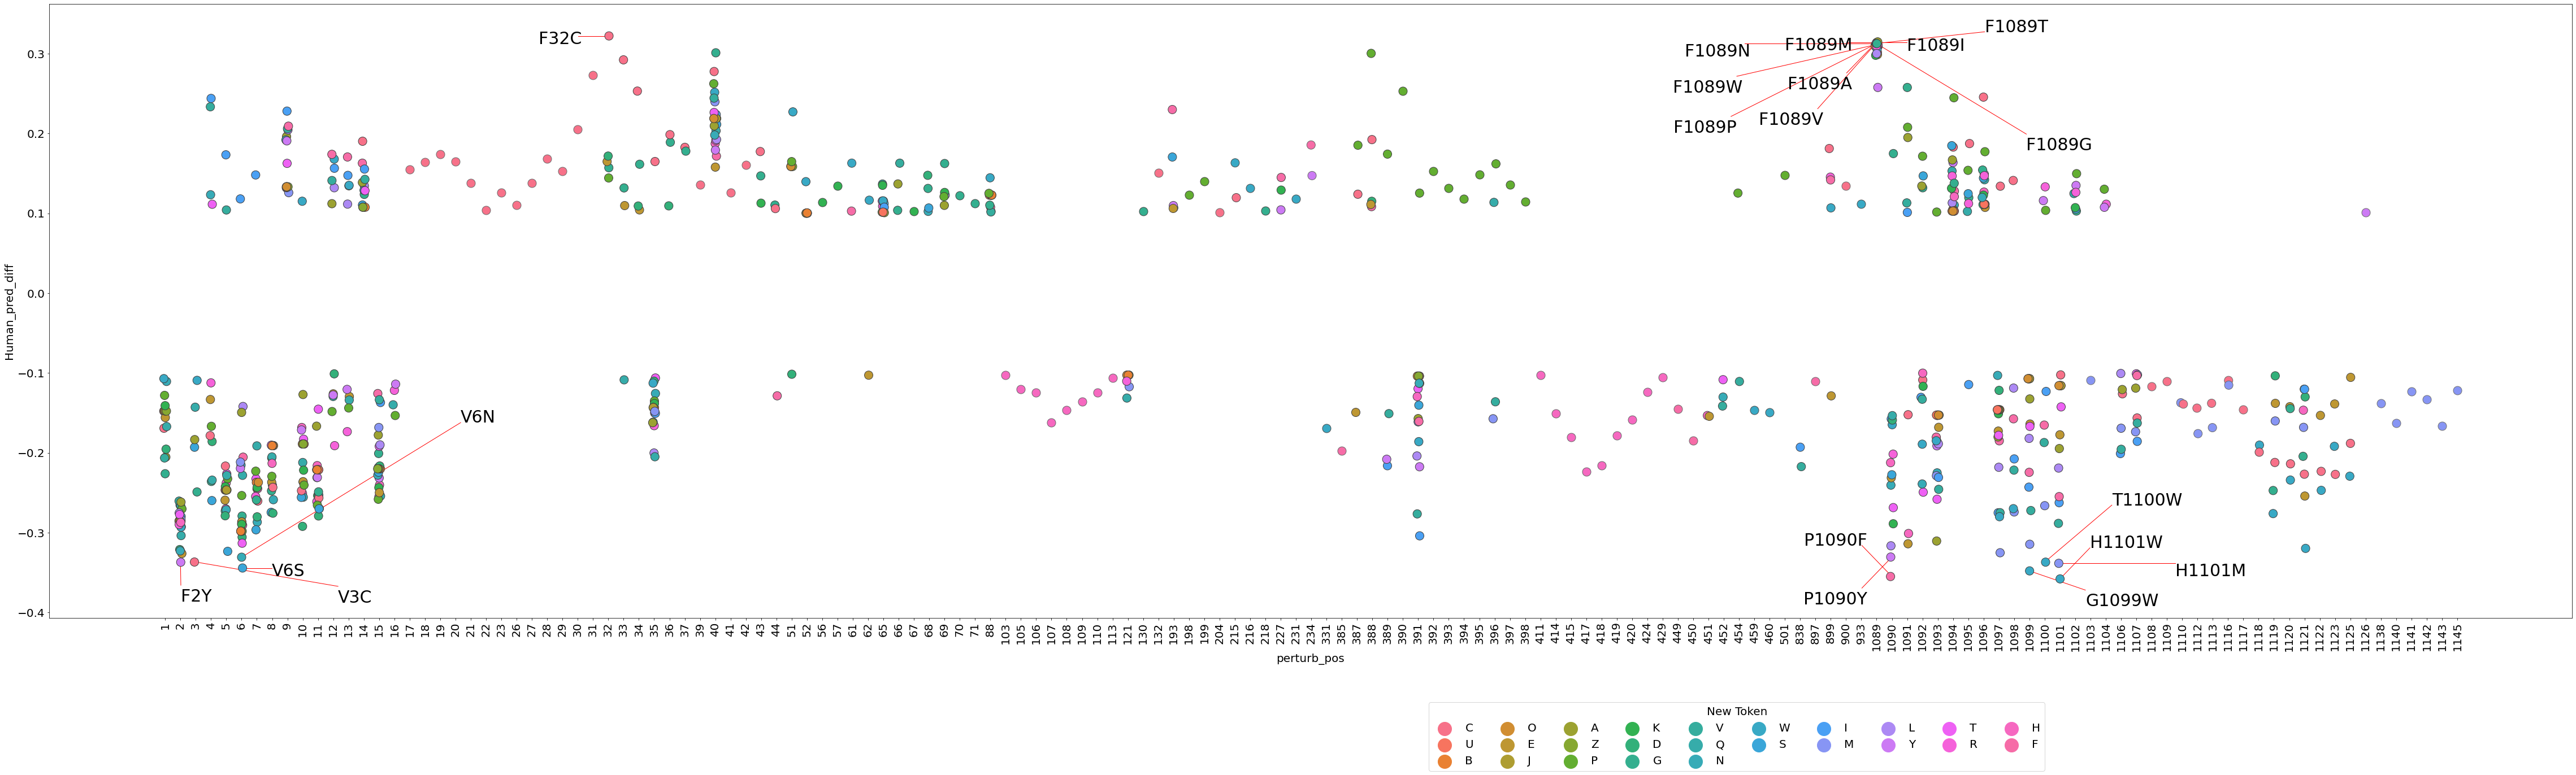

In [26]:
plt.clf()
plt.figure(figsize=(80, 20))
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [27]:
cut_off_df_2["perturbation_id"].nunique()

855

<Figure size 432x288 with 0 Axes>

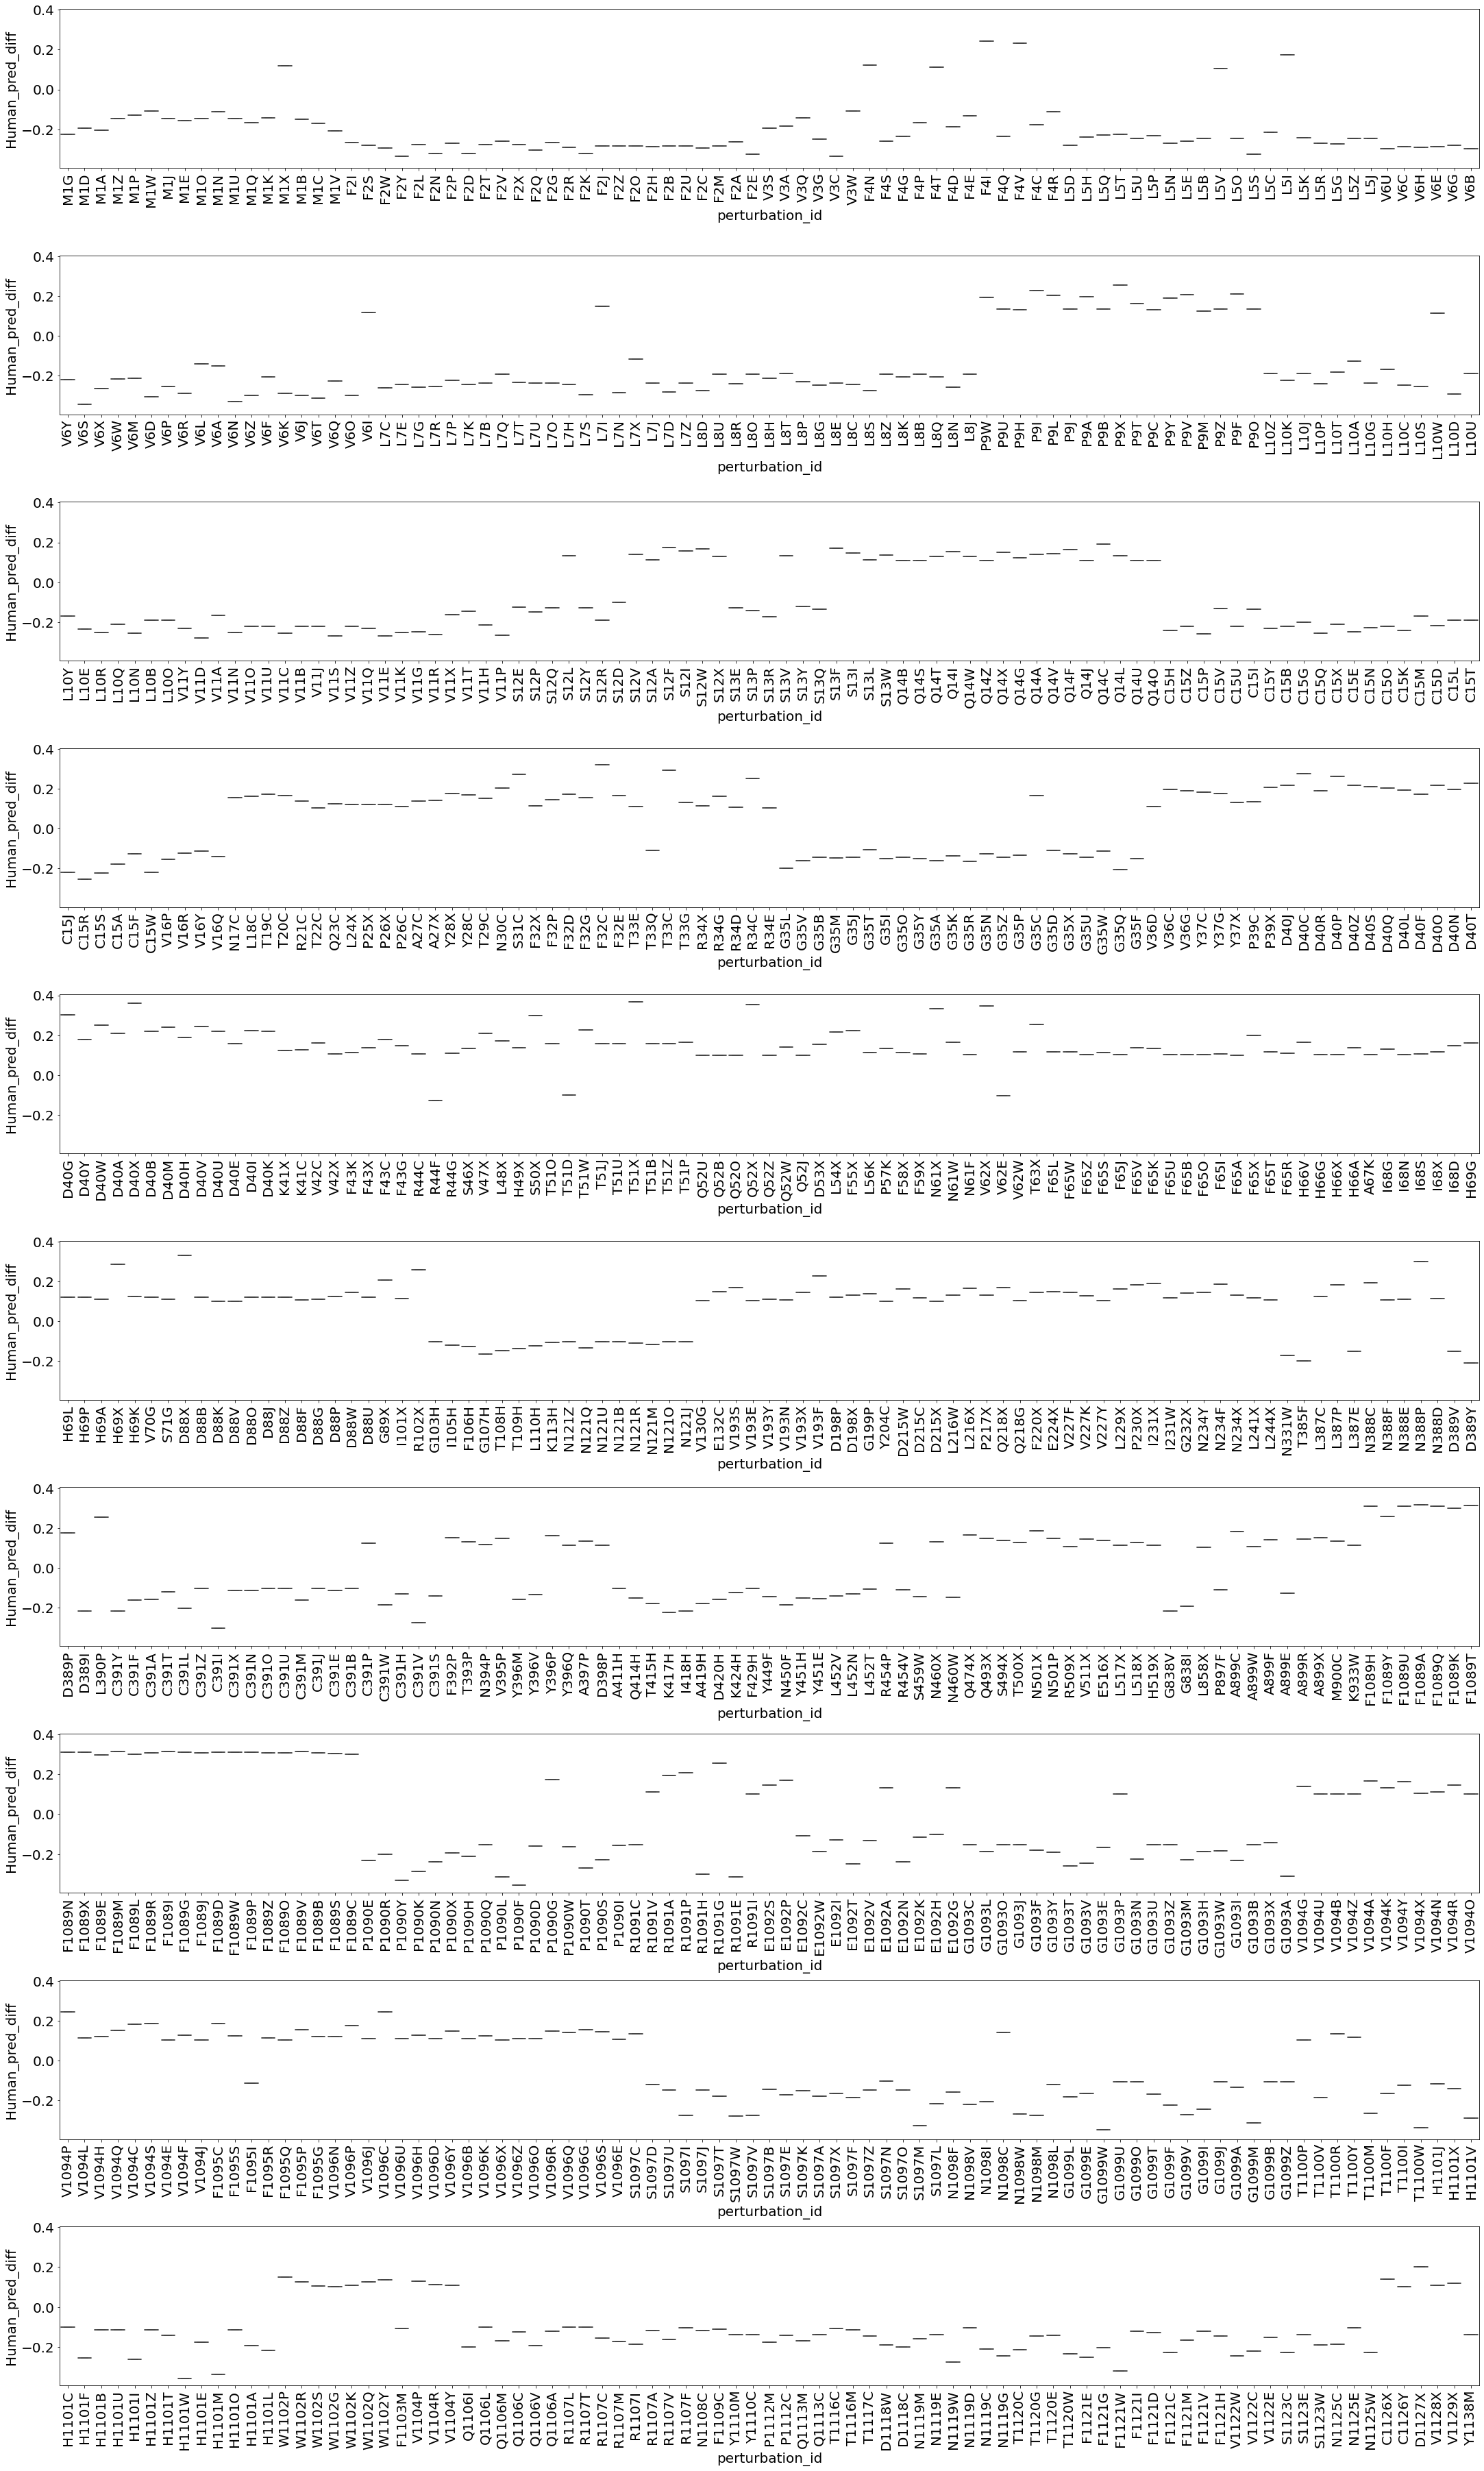

In [28]:
plt.clf()
n = 10
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

perturbation_ids = cut_off_df_2.sort_values("perturb_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(n, 1, figsize=(30, 50), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbation_ids), n)

for i in range(n):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(bins[i])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[i], orient="v", order=bins[i],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [29]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..","..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_WIV04_mutations_grouped_filtered.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
#s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

,spike_mutations,pango_lineage,variant_count
0,A222V,['B.1.177'],1
1,A264D,"['JN.1', 'JN.4']",2
2,A27S,"['BA.2', 'BA.2.12.1', 'BA.2.75', 'JN.1', 'BA.4...",27
3,A475V,"['XBB.1.5', 'JD.1.1', 'JD.1.1.1', 'GW.5.1.1', ...",5
4,A570D,['B.1.1.7'],1
...,...,...,...
130,V83A,"['EG.5.1', 'XBB.1.5', 'JD.1.1', 'JD.1.1.1', 'J...",16
131,W152C,"['B.1.427, B.1.429']",1
132,W152R,['BA.2.75'],1
133,Y248H,"['XBB.1.5', 'JD.1.1.1']",2


In [30]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_pos']}{x['new_token']}", axis=1)

In [31]:
mutation_variant_heatmap_df = pd.read_csv(os.path.join(os.getcwd(), "..", "..", "..","..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_WIV04_mutations_filtered_heatmap.csv"))
mutation_variant_heatmap_df.set_index("spike_mutations", inplace=True)
mutation_variant_heatmap_df

,B.1.1.1.C37,B.1.1.28.1,B.1.1.28.2,B.1.1.28.3,B.1.1.318,B.1.1.7,B.1.177,B.1.214.2,B.1.351,B.1.375,...,HK.3.2,HV.1,JD.1.1,JD.1.1.1,JG.3,JN.1,JN.4,XBB,XBB.1,XBB.1.5
spike_mutations,,,,,,,,,,,,,,,,,,,,,
A222V,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A264D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
A27S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
A475V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0
A570D,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V83A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0
W152C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W152R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["spike_mutations"])]

# s_mutations_df = s_mutations_df.merge(known_mutations_df[["perturbation_id", "label"]], on="perturbation_id")
# s_mutations_df

<Figure size 432x288 with 0 Axes>

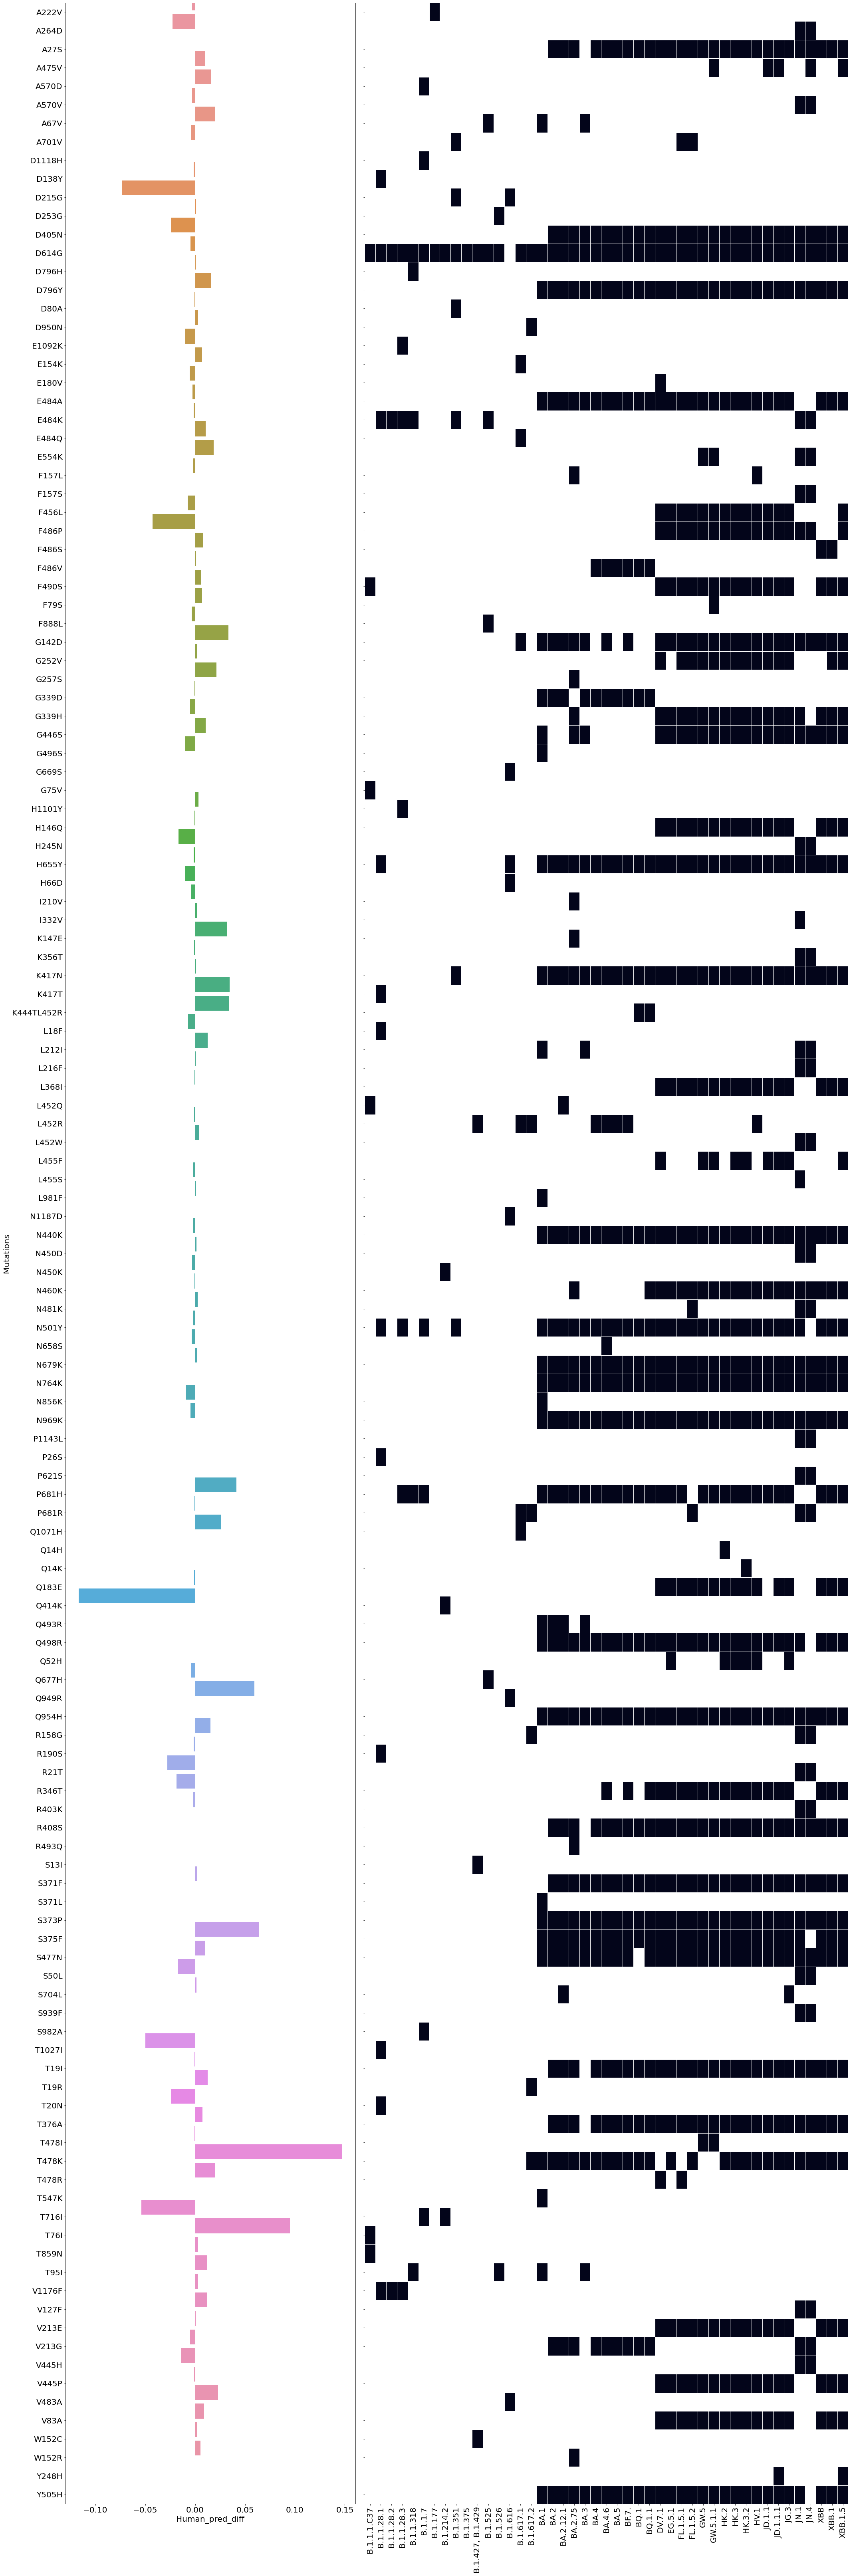

In [33]:
plt.clf()
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

fig, axs = plt.subplots(1, 2, figsize=(30, 90), sharex=False, sharey=True, gridspec_kw={'width_ratios': [.6, 1]})


sns.barplot(data=known_mutations_df, y="perturbation_id", x="Human_pred_diff", ax=axs[0], dodge=False)
    
axs[0].set_ylabel("Mutations")
    #axs.tick_params(axis='x', rotation=90)
sns.heatmap(mutation_variant_heatmap_df, linewidth=.5, ax=axs[1], cmap=sns.cm.rocket_r, cbar=False, vmin=0, vmax=1)
# plt.tight_layout(pad=.2)
axs[1].set_ylabel("")
plt.tight_layout()
plt.show()

### Identified and Known Mutations

In [34]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["spike_mutations"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 855
known_mutations = 135
intersection = {'S13I', 'E1092K'}
